In [1]:
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(49)

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

In [5]:
dataset_ex_df = pd.read_csv('TSLA.csv', header=0, parse_dates=[0], date_parser=parser)

In [6]:
dataset_ex_df.head()

,Date,TSLA
0,2010-06-30,4.766
1,2010-07-01,4.392
2,2010-07-02,3.840
3,2010-07-06,3.222
4,2010-07-07,3.160


In [7]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2393 number of days in the dataset.


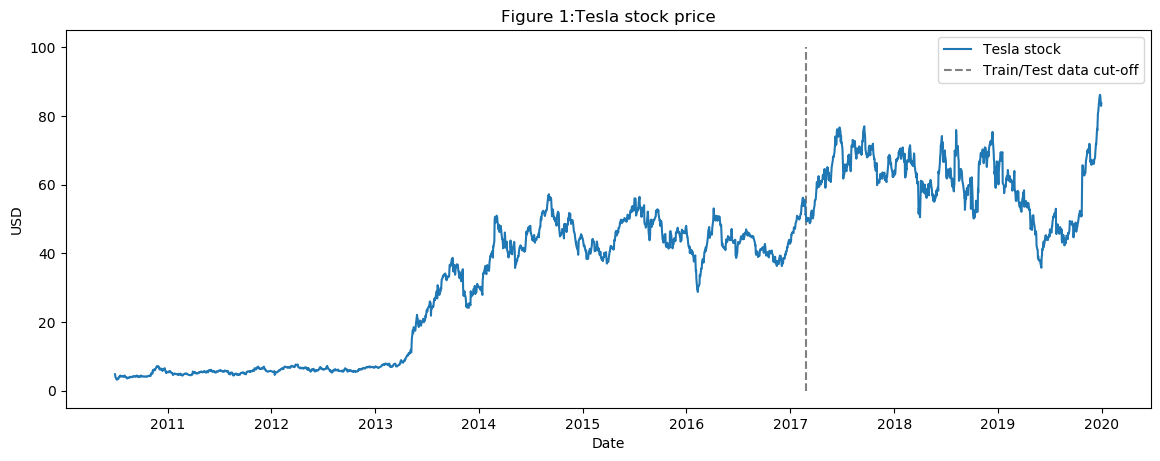

In [8]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['TSLA'], label='Tesla stock')
plt.vlines(datetime.date(2017,2, 24), 0, 100, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1:Tesla stock price')
plt.legend()
plt.show()

In [9]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1675. Number of test days: 718.


In [10]:
#adding stocks
correlated_stocks = ['F', 'FCAU', 'GM', 'HMC', 'HYMTF', 'NSANY', 'PUGOY', 'RNOPA', 'TM', 'VOW3DE']
for i in correlated_stocks:
    dataset_tmpr = pd.read_csv('correlated_assets/stocks/'+str(i)+'.csv', header=0, parse_dates=[0], date_parser=parser)
    dataset_tmpr = dataset_tmpr[(dataset_tmpr['Date'] > '2010-06-29') & (dataset_tmpr['Date'] < '2020-01-01')]
    
    dataset_tmpr = dataset_tmpr.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1).reset_index(drop = True)
    dataset_tmpr.columns = ['Date', i]
    dataset_ex_df = dataset_ex_df.merge(dataset_tmpr, how = 'left', on = 'Date')    
    

In [11]:
#adding libor rates
correlated_rates = ['ukousd6m_d', 'ukousd1w_d', 'ukousd1m_d', 'ukogbp6m_d', 'ukogbp1w_d', 'ukogbp1m_d'] 
for i in correlated_rates:
    dataset_tmpr = pd.read_csv('correlated_assets/libor/'+str(i)+'.csv', header=0, parse_dates=[0], date_parser=parser)
    dataset_tmpr = dataset_tmpr[(dataset_tmpr['Date'] > '2010-06-29') & (dataset_tmpr['Date'] < '2020-01-01')]
    
    dataset_tmpr = dataset_tmpr.drop(['Otwarcie', 'Najnizszy', 'Najwyzszy'], axis = 1).reset_index(drop = True)
    dataset_tmpr.columns = ['Date', i]
    dataset_ex_df = dataset_ex_df.merge(dataset_tmpr, how = 'left', on = 'Date')    
    

In [12]:
#adding indices
correlated_indices = ['^VIX', '^spx_d', '^shc_d', '^nkx_d', '^ndx_d', '^ndq_d', '^hsi_d', '^djt_d', 
                      '^dji_d', '^djc_d', '^dax_d']

for i in correlated_indices:
    dataset_tmpr = pd.read_csv('correlated_assets/indices/'+str(i)+'.csv', header=0, parse_dates=[0], date_parser=parser)
    dataset_tmpr = dataset_tmpr[(dataset_tmpr['Date'] > '2010-06-29') & (dataset_tmpr['Date'] < '2020-01-01')]
    dataset_tmpr = dataset_tmpr.drop(['Otwarcie', 'Najnizszy', 'Najwyzszy'], axis = 1).reset_index(drop = True)
    dataset_tmpr.columns = ['Date', i]
    dataset_ex_df = dataset_ex_df.merge(dataset_tmpr, how = 'left', on = 'Date')    

In [13]:
#adding currencies
correlated_currencies = ['usdjpy_d', 'usdgbp_d', 'usdeur_d', 'usdchf_d']

for i in correlated_currencies:
    dataset_tmpr = pd.read_csv('correlated_assets/currencies/'+str(i)+'.csv', header=0, parse_dates=[0], date_parser=parser)
    dataset_tmpr = dataset_tmpr[(dataset_tmpr['Data'] > '2010-06-29') & (dataset_tmpr['Data'] < '2020-01-01')]
    dataset_tmpr = dataset_tmpr.drop(['Otwarcie', 'Najnizszy', 'Najwyzszy'], axis = 1).reset_index(drop = True)
    dataset_tmpr.columns = ['Date', i]
    dataset_ex_df = dataset_ex_df.merge(dataset_tmpr, how = 'left', on = 'Date')    

In [14]:
#adding commodities
correlated_commodities = ['rb_f_d', 'gc_f_d', 'cl_f_d', 'cb_f_d']

for i in correlated_commodities:
    dataset_tmpr = pd.read_csv('correlated_assets/commodities/'+str(i)+'.csv', header=0, parse_dates=[0], date_parser=parser)
    dataset_tmpr = dataset_tmpr[(dataset_tmpr['Data'] > '2010-06-29') & (dataset_tmpr['Data'] < '2020-01-01')]
    dataset_tmpr = dataset_tmpr.drop(['Otwarcie', 'Najnizszy', 'Najwyzszy'], axis = 1).reset_index(drop = True)
    dataset_tmpr.columns = ['Date', i]
    dataset_ex_df = dataset_ex_df.merge(dataset_tmpr, how = 'left', on = 'Date')    

In [15]:
#adding bonds
correlated_commodities = ['30usy_b_d', '10usy_b_d']

for i in correlated_commodities:
    dataset_tmpr = pd.read_csv('correlated_assets/bonds/'+str(i)+'.csv', header=0, parse_dates=[0], date_parser=parser)
    dataset_tmpr = dataset_tmpr[(dataset_tmpr['Data'] > '2010-06-29') & (dataset_tmpr['Data'] < '2020-01-01')]
    dataset_tmpr = dataset_tmpr.drop(['Otwarcie', 'Najnizszy', 'Najwyzszy'], axis = 1).reset_index(drop = True)
    dataset_tmpr.columns = ['Date', i]
    dataset_ex_df = dataset_ex_df.merge(dataset_tmpr, how = 'left', on = 'Date')    

In [16]:
dataset_ex_df = dataset_ex_df.fillna(method = 'ffill')
#last resort
dataset_ex_df = dataset_ex_df.fillna(method = 'bfill')

In [18]:
dataset_ex_df.describe()

,TSLA,F,FCAU,GM,HMC,HYMTF,NSANY,PUGOY,RNOPA,TM,...,usdjpy_d,usdgbp_d,usdeur_d,usdchf_d,rb_f_d,gc_f_d,cl_f_d,cb_f_d,30usy_b_d,10usy_b_d
count,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,...,2393.000000,2393.000000,2393.000000,2393.00000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000
mean,36.644003,12.774563,9.091699,33.223234,32.520715,39.921889,18.669975,20.043310,61.805157,109.345374,...,101.721467,0.686948,0.822523,0.95499,2.158193,1358.419143,72.212206,80.077397,3.121261,2.334047
std,22.893887,2.538164,5.244665,5.432221,4.346148,11.635187,2.119022,8.591215,19.906025,21.575270,...,14.226043,0.070331,0.074687,0.04609,0.613970,177.790610,22.366675,26.250693,0.550424,0.491088
min,3.160000,7.630000,2.802632,18.799999,22.900000,19.000000,11.540000,5.620000,22.340000,60.389999,...,75.820000,0.582600,0.674400,0.72130,0.907500,1050.300000,27.290000,27.770000,1.938000,1.362900
25%,6.868000,10.840000,4.973684,30.600000,29.110001,30.500000,17.719999,14.710000,43.154999,86.779999,...,85.840000,0.628700,0.754300,0.92633,1.614200,1233.600000,51.730000,56.690000,2.798700,1.933000
50%,42.326000,12.510000,7.190000,34.189999,32.150002,39.500000,19.080000,18.840000,61.290001,116.239998,...,106.406000,0.655600,0.821600,0.96429,2.026000,1303.000000,68.260000,74.710000,3.027000,2.312000
75%,52.779999,14.970000,12.300000,36.750000,35.590000,45.529999,20.139999,24.000000,79.529999,125.120003,...,112.002000,0.761160,0.891460,0.98996,2.746800,1468.100000,93.970000,107.940000,3.351000,2.691000
max,86.188004,18.790001,24.809999,46.480000,44.490002,80.000000,24.049999,45.849998,98.809998,145.320007,...,125.650000,0.831360,0.962440,1.07770,3.410000,1898.450000,113.860000,126.760000,4.773000,3.725000
